# Part 0: Data Loading

In [1]:
# Install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = '1oGPFPWM_b8LgISDRiYckgURM9cMACfmE'
file = drive.CreateFile({'id':id}) 
file.GetContentFile('bank.csv')

In [2]:
# Load the dataset into a Pandas DataFrame
import numpy as np
import pandas as pd

df = pd.read_csv('bank.csv')

# Part 1: Exploratory Data Analysis

### Part 1.1: Examine the Raw Dataset

In [3]:
# See the first few observations in the dataset
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
# Show the number of unique values for each column
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Number of unchurned customers: 7963
Number of churned customers: 2037



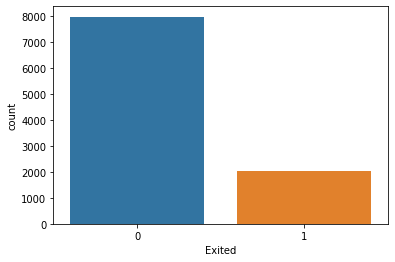

In [6]:
# Count the churned observations in the dataset
import seaborn as sns

print('Number of unchurned customers: {}'.format((df['Exited'] == 0).sum()))
print('Number of churned customers: {}\n'.format((df['Exited'] == 1).sum()))
sns.countplot(x='Exited', data=df)

In [7]:
# Variable y stores the target column for prediction
y = df['Exited']

### Part 1.2: Examine the Features

#### Part 1.2.1: Missing Values

In [8]:
# Count missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

No missing value in the dataset.

#### Part 1.2.2: Numerical Features

In [9]:
# Numerical features: CreditScore, Age, Tenure, Balance, NumberOfProducts, EstimatedSalary
num_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df[num_features].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,100090.239881
std,96.653299,10.487806,2.892174,62397.405202,0.581654,57510.492818
min,350.000000,18.000000,0.000000,0.000000,1.000000,11.580000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,51002.110000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,100193.915000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,149388.247500
max,850.000000,92.000000,10.000000,250898.090000,4.000000,199992.480000


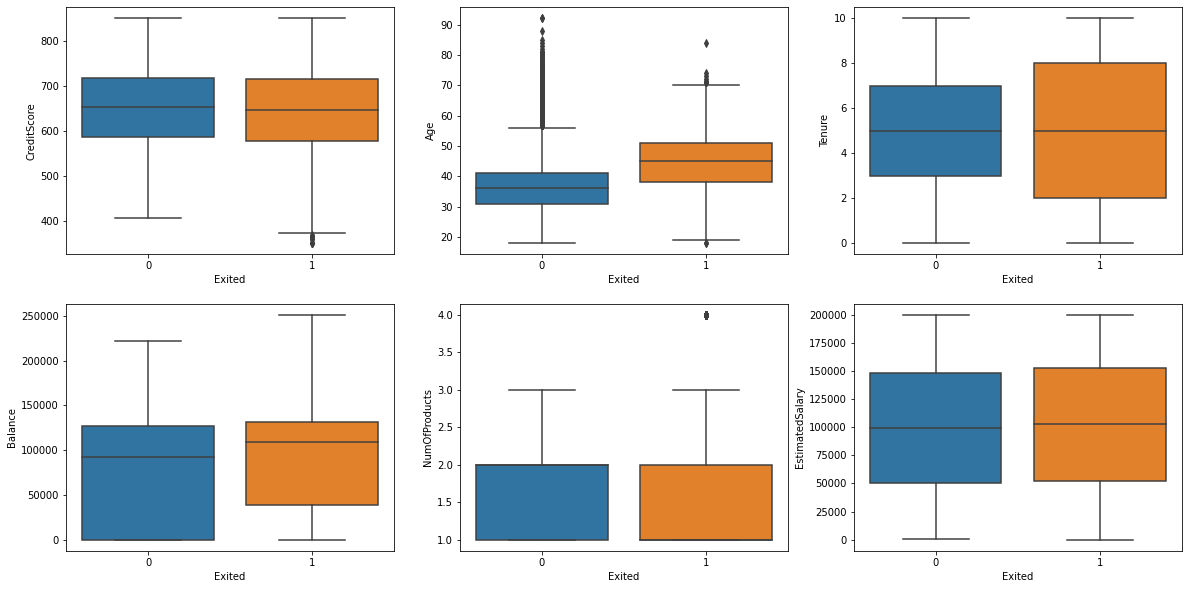

In [10]:
# Show distributions
%matplotlib inline
import matplotlib.pyplot as plt

# Draw a box plot for each numerical feature.
_, axss = plt.subplots(2, 3, figsize=[20, 10])
for i in range(len(num_features)):
    sns.boxplot(x='Exited', y=num_features[i], data=df, ax=axss[i//3][i%3])

A first glimpse of feature value distributions shows that **customer's age** might be a factor that affects the churn rate.

#### Part 1.2.3: Categorical Features

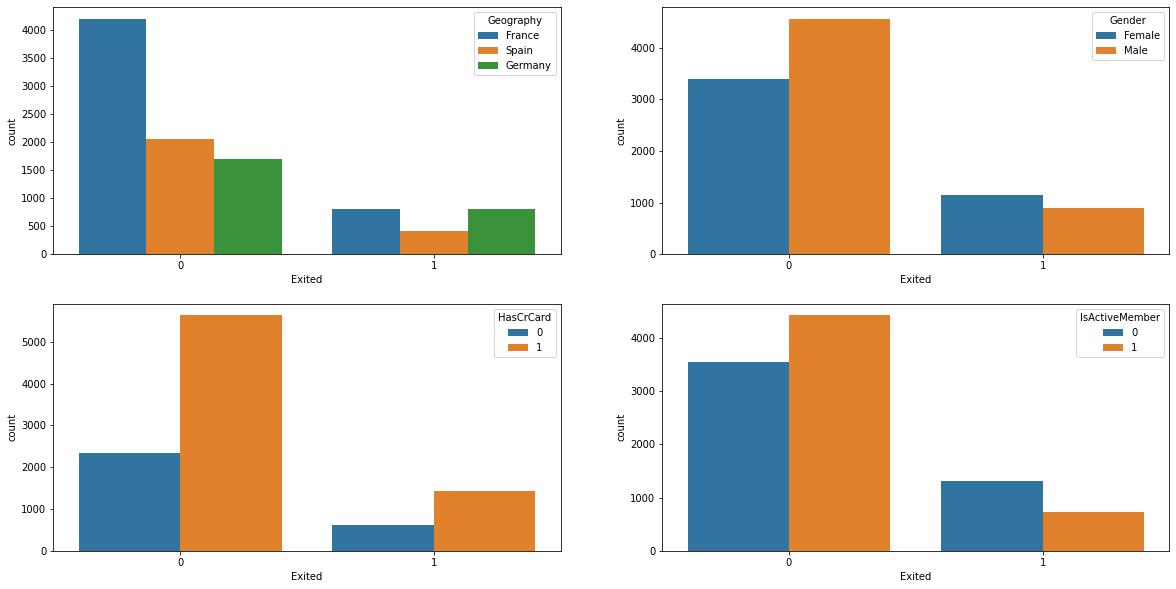

In [11]:
# Categorical features: Geography, Gender, HasCrCard, IsActiveMember
cat_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
_, axss = plt.subplots(2, 2, figsize=[20, 10])
for i in range(len(cat_features)):
    sns.countplot(x='Exited', hue=cat_features[i], data=df, ax=axss[i//2][i%2])

It is revealed from the figures that in this dataset, **female customers** have a higher churn rate than males. And the proportion of churns are lower among **avtive customers**.

# Part 2: Feature Engineering

### Part 2.1: Drop Useless Features

In [12]:
# Row number, customer ID, and customer surname are irrelevant features for churn prediction
dropped_cols = ['RowNumber', 'CustomerId', 'Surname', 'Exited']
X = df.drop(dropped_cols, axis=1)
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


### Part 2.2: Obtain Numerical and Categorical Columns

In [13]:
# Check the data type of each column
X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [14]:
# Get numerical and categorical columns respectively
numerical_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')]
categorical_cols = X.columns[X.dtypes == 'object']

print('Numerical columns:\n{}\n'.format(numerical_cols))
print('Categorical columns:\n{}'.format(categorical_cols))

Numerical columns:
Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

Categorical columns:
Index(['Geography', 'Gender'], dtype='object')


### Part 2.3: Split Dataset

In [15]:
# Split the dataset into a training set and a test set using stratified sampling 
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify=y, random_state=1)

print('Shape of training set: {} x {}'.format(X_train.shape[0], X_train.shape[1]))
print('Shape of test set:     {} x {}'.format(X_test.shape[0], X_test.shape[1]))

Shape of training set: 7500 x 10
Shape of test set:     2500 x 10


### Part 2.4: Categorical Feature Encoding

In [16]:
# One hot encoding is used to process categorical features with more than 2 classes
from sklearn.preprocessing import OneHotEncoder

'''
This function encodes columns of dataframe specified in categories
using the given encoder, append the encoded columns to dataframe,
and drop the original columns.
'''
def one_hot_encoding(dataframe, encoder, categories):  
  transformed = pd.DataFrame(
      encoder.transform(dataframe[categories]).toarray(), 
      columns=encoder.get_feature_names_out(categories)
  )
  return pd.concat([dataframe.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)

categories_ohe = ['Geography'] # Feature with 3 classes
encoder_onehot = OneHotEncoder()
encoder_onehot.fit(X_train[categories_ohe])

X_train = one_hot_encoding(X_train, encoder_onehot, categories_ohe)
X_test = one_hot_encoding(X_test, encoder_onehot, categories_ohe)

In [17]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,633,Male,42,10,0.00,1,0,1,79408.17,0.0,0.0,1.0
1,708,Female,23,4,71433.08,1,1,0,103697.57,0.0,1.0,0.0
2,548,Female,37,9,0.00,2,0,0,98029.58,1.0,0.0,0.0
3,645,Female,48,7,90612.34,1,1,1,149139.13,1.0,0.0,0.0
4,729,Female,45,7,91091.06,2,1,0,71133.12,0.0,0.0,1.0


In [18]:
# Ordinal encoding is used to process categorical features with 2 classes
from sklearn.preprocessing import OrdinalEncoder

categories_oe = ['Gender'] # Feature with 2 classes
encoder_ordinal = OrdinalEncoder()
encoder_ordinal.fit(X_train[categories_oe])

X_train[categories_oe] = encoder_ordinal.transform(X_train[categories_oe])
X_test[categories_oe] = encoder_ordinal.transform(X_test[categories_oe])

In [19]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,633,1.0,42,10,0.00,1,0,1,79408.17,0.0,0.0,1.0
1,708,0.0,23,4,71433.08,1,1,0,103697.57,0.0,1.0,0.0
2,548,0.0,37,9,0.00,2,0,0,98029.58,1.0,0.0,0.0
3,645,0.0,48,7,90612.34,1,1,1,149139.13,1.0,0.0,0.0
4,729,0.0,45,7,91091.06,2,1,0,71133.12,0.0,0.0,1.0


### Part 2.5: Feature Standardization

In [20]:
# Standardize the numerical features
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(X_train[numerical_cols])
X_train[numerical_cols] = std_scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = std_scaler.transform(X_test[numerical_cols])

In [21]:
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.172985,1.0,0.289202,1.731199,-1.218916,-0.912769,-1.542199,0.968496,-0.352044,0.0,0.0,1.0
1,0.602407,0.0,-1.509319,-0.341156,-0.076977,-0.912769,0.648425,-1.032529,0.072315,0.0,1.0,0.0
2,-1.051762,0.0,-0.184093,1.385806,-1.218916,0.796109,-1.542199,-1.032529,-0.026711,1.0,0.0,0.0
3,-0.048922,0.0,0.857156,0.695022,0.229625,-0.912769,0.648425,0.968496,0.866221,1.0,0.0,0.0
4,0.819517,0.0,0.573179,0.695022,0.237278,0.796109,0.648425,-1.032529,-0.496617,0.0,0.0,1.0


# Part 3: Model Training and Evaluation

### Part 3.1: Model Training with Default Parameters

In [22]:
# Construct classification models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

model_lr = LogisticRegression()
model_knn = KNeighborsClassifier()
model_rf = RandomForestClassifier()
model_xgb = XGBClassifier()

In [23]:
# Perform k-fold cross validation to evaluate model prediction accuracy
models = [model_lr, model_knn, model_rf, model_xgb]
accuracies = []
for model in models:
    cv_scores = model_selection.cross_val_score(model, X_train, y_train, cv=10)
    accuracies.append(cv_scores.mean())

In [24]:
print('''
Model Validation Accuracy
Logistic Regression: {}
K Nearest Neighbors: {}
Random Forest:       {}
XGBoost:             {}
'''.format(*accuracies))


Model Validation Accuracy
Logistic Regression: 0.8107999999999999
K Nearest Neighbors: 0.8353333333333334
Random Forest:       0.8646666666666668
XGBoost:             0.8657333333333334



### Part 3.2: Hyperparameter Optimization with Grid Search

In [25]:
from sklearn.model_selection import GridSearchCV

'''
This function takes a model and a set of parameters, and performs 
grid search cross validation. The best set of parameters and the
validation accuracy are printed out. Then, the best model will be
evaluated based on the test set. The final test accuracy is printed.
The best model will be returned.
'''
def validate_and_test(model, params, model_name):
    print('Model: {}\n'.format(model_name))

    # Cross Validation
    gscv = GridSearchCV(model, params, cv=10)
    gscv.fit(X_train, y_train)
    print('Best parameter set: {}\nBest validation accuracy: {}'\
        .format(gscv.best_params_, gscv.best_score_))
    
    # Model Testing
    best_model = gscv.best_estimator_
    test_accuracy = best_model.score(X_test, y_test)
    print('Test accuracy: {}'.format(test_accuracy))

    return best_model

#### Part 3.2.1: Model 1 - Logistic Regression

In [26]:
model_lr = LogisticRegression(solver='liblinear')
params_lr = {
    'penalty': ('l1', 'l2'), 
    'C': (0.01, 0.05, 0.1, 0.2, 0.5, 1)
}

best_model_lr = validate_and_test(model_lr, params_lr, 'Logistic Regression')

Model: Logistic Regression

Best parameter set: {'C': 0.1, 'penalty': 'l1'}
Best validation accuracy: 0.812
Test accuracy: 0.8108


#### Part 3.2.2: Model 2 - KNN

In [27]:
model_knn = KNeighborsClassifier()
params_knn = {
    'n_neighbors': range(1, 30, 4),
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
}

best_model_knn = validate_and_test(model_knn, params_knn, 'K Nearest Neighbors')

Model: K Nearest Neighbors

Best parameter set: {'algorithm': 'auto', 'n_neighbors': 17}
Best validation accuracy: 0.8443999999999999
Test accuracy: 0.8368


#### Part 3.2.3: Model 3 - Random Forest

In [28]:
model_rf = RandomForestClassifier()
params_rf = {
    'n_estimators': range(40, 141, 20),
    'max_depth': range(1, 20, 2),
}

best_model_rf = validate_and_test(model_rf, params_rf, 'Random Forest')

Model: Random Forest

Best parameter set: {'max_depth': 13, 'n_estimators': 80}
Best validation accuracy: 0.8666666666666666
Test accuracy: 0.8588


#### Part 3.2.4: Model 4 - XGBoost

In [29]:
model_xgb = XGBClassifier()
params_xgb = {
    'booster': ['gbtree', 'gblinear'],
	'eta': [0.1, 0.5, 1],
    'max_depth': range(3, 11, 3),
	'n_estimators': range(20, 101, 20),
	'subsample': [0.25, 0.5, 1]
}

best_model_xgb = validate_and_test(model_xgb, params_xgb, 'XGBoost')

Model: XGBoost

Best parameter set: {'booster': 'gbtree', 'eta': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
Best validation accuracy: 0.8669333333333332
Test accuracy: 0.8616


### Part 3.3: Model Evaluation


#### Part 3.3.1: Accuracy, Precision, Recall, and F1-Score


In [30]:
model_names = ['Logistic Regression', 'K Nearest Neighbor', 'Random Forest', 'XGBoost']
best_models = [best_model_lr, best_model_knn, best_model_rf, best_model_xgb]
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

# Stores test statistics
test_results = {
    'Logistic Regression': [],
    'K Nearest Neighbor': [],
    'Random Forest': [],
    'XGBoost': []
}

In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

'''
This function evalutate the input model by four metrics:
accuracy, precision, recall, and f1-score.
'''
def evaluate(model, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    test_results[model_name].extend([accuracy, precision, recall, f1])
    print('Model:     {}'.format(model_name))
    print('Accuracy:  {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall:    {}'.format(recall))
    print('F1-Score:  {}'.format(f1))
    print()

In [32]:
for i in range(len(model_names)):
    evaluate(best_models[i], model_names[i])

Model:     Logistic Regression
Accuracy:  0.8108
Precision: 0.6153846153846154
Recall:    0.18860510805500982
F1-Score:  0.2887218045112782

Model:     K Nearest Neighbor
Accuracy:  0.8368
Precision: 0.7327188940092166
Recall:    0.31237721021611004
F1-Score:  0.4380165289256199

Model:     Random Forest
Accuracy:  0.8588
Precision: 0.7785714285714286
Recall:    0.42829076620825146
F1-Score:  0.5525982256020279

Model:     XGBoost
Accuracy:  0.8616
Precision: 0.7654723127035831
Recall:    0.46168958742632615
F1-Score:  0.5759803921568628



#### Part 3.3.2: ROC & AUC

In [33]:
from sklearn.metrics import roc_curve
from sklearn import metrics

'''
This function draws the ROC curve for the input model
and calculates the AUC value.
'''
def draw_roc_curve(model, model_name):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    # Calculate AUC
    auc = metrics.auc(fpr, tpr)
    test_results[model_name].append(auc)
    print('{}\nAUC = {}\n'.format(model_name, auc))

    # Draw plot
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name)
    plt.legend(loc='best')
    plt.show()

Logistic Regression
AUC = 0.7718515243941548



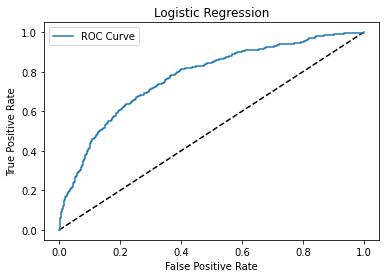

K Nearest Neighbor
AUC = 0.8070299649009935



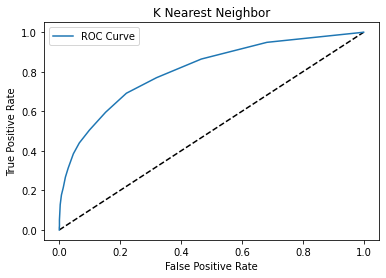

Random Forest
AUC = 0.8400987153388677



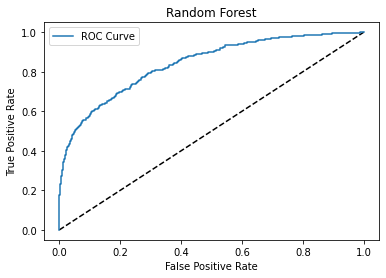

XGBoost
AUC = 0.8516516860252276



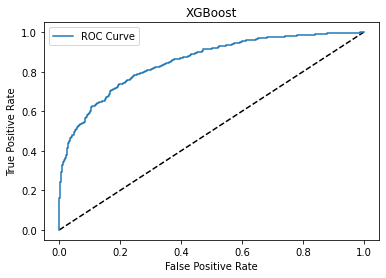

In [34]:
for best_model, model_name in zip(best_models, model_names):
    draw_roc_curve(best_model, model_name)

#### Part 3.3.3: Test Metrics Summary

In [35]:
best_models

[LogisticRegression(C=0.1, penalty='l1', solver='liblinear'),
 KNeighborsClassifier(n_neighbors=17),
 RandomForestClassifier(max_depth=13, n_estimators=80),
 XGBClassifier(eta=0.1, subsample=0.5)]

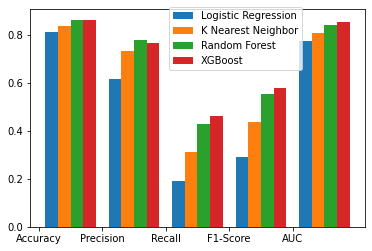

In [36]:
# Compare the models using 5 metrics
x_axis = np.arange(len(test_metrics))
for i in range(len(best_models)):
    plt.bar(x_axis+0.20*(i+1), test_results[model_names[i]], width=0.2, label=model_names[i])
plt.xticks(x_axis, test_metrics)
plt.legend(bbox_to_anchor=(0.4, 0.7))
plt.show()

Model performance with respect to all the test metrics except precision:

XGBoost > Random Forest > K Nearest Neighbor > Logistic Regression

# Part 4: Feature Impact Analysis

### Part 4.1:  Logistic Regression - Feature Coefficient

In [37]:
# Feature encoding on the entire dataset
X = one_hot_encoding(X, encoder_onehot, categories_ohe)
X[categories_oe] = encoder_ordinal.transform(X[categories_oe])

# Standardization
std_scaler = StandardScaler()
std_scaler.fit(X[numerical_cols])
X[numerical_cols] = std_scaler.transform(X[numerical_cols])
X.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.326221,0.0,0.293517,-1.041760,-1.225848,-0.911583,0.646092,0.970243,0.021886,1.0,0.0,0.0
1,-0.440036,0.0,0.198164,-1.387538,0.117350,-0.911583,-1.547768,0.970243,0.216534,0.0,0.0,1.0
2,-1.536794,0.0,0.293517,1.032908,1.333053,2.527057,0.646092,-1.030670,0.240687,1.0,0.0,0.0
3,0.501521,0.0,0.007457,-1.387538,-1.225848,0.807737,-1.547768,-1.030670,-0.108918,1.0,0.0,0.0
4,2.063884,0.0,0.388871,-1.041760,0.785728,-0.911583,0.646092,0.970243,-0.365276,0.0,0.0,1.0


In [38]:
# Train a logistic regression model on the entire dataset
model_lr = LogisticRegression(penalty='l1', C = 0.1, solver='liblinear')
model_lr.fit(X, y)

# Print coefficients in descending order of their absolute value
indices = np.argsort(abs(model_lr.coef_[0]))[::-1]
print('Coefficients in Logistic Regression\n')
for i in range(X.shape[1]):
  print('{:>17}   {}'.format(X.columns[indices[i]], round(model_lr.coef_[0][indices[i]], 4)))

Coefficients in Logistic Regression

              Age   0.7489
 Geography_France   -0.7325
  Geography_Spain   -0.6814
   IsActiveMember   -0.5238
           Gender   -0.512
          Balance   0.1658
      CreditScore   -0.0569
    NumOfProducts   -0.0514
           Tenure   -0.0381
  EstimatedSalary   0.0202
        HasCrCard   -0.0126
Geography_Germany   0.0


Judging from the coefficients of Logistic Regression, **customer's age** seems to have a significant positive effect on the increase of churn rate. Besides, **Franch and Spainish customers** tend not to churn as indicated by the result.

### Part 4.2:  Random Forest - Feature Importance

In [39]:
# Train a random forest model on the entire dataset
model_rf = RandomForestClassifier(n_estimators=100, max_depth=15)
model_rf.fit(X, y)

# Print the feature importance in descending order
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
print('Feature importance in Random Forest\n')
for i in range(X.shape[1]):
  print ('{: >17}   {}'.format(X.columns[indices[i]], round(importances[indices[i]], 4)))

Feature importance in Random Forest

              Age   0.2542
    NumOfProducts   0.1493
          Balance   0.1374
  EstimatedSalary   0.1321
      CreditScore   0.1313
           Tenure   0.073
   IsActiveMember   0.0443
Geography_Germany   0.0231
           Gender   0.0181
        HasCrCard   0.0167
 Geography_France   0.0111
  Geography_Spain   0.0094


**Customer's age, number of products subscribed, balance, estimated salary, and credit score** turn out to be relatively important factors for predicting churns.

### Part 4.3:  Random Forest - SHAP Values

In [40]:
!pip install shap

import shap

# Calculate SHAP values
explainer = shap.Explainer(best_model_rf.predict, X_test)
shap_values = explainer(X_test)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Permutation explainer: 2501it [29:44,  1.40it/s]


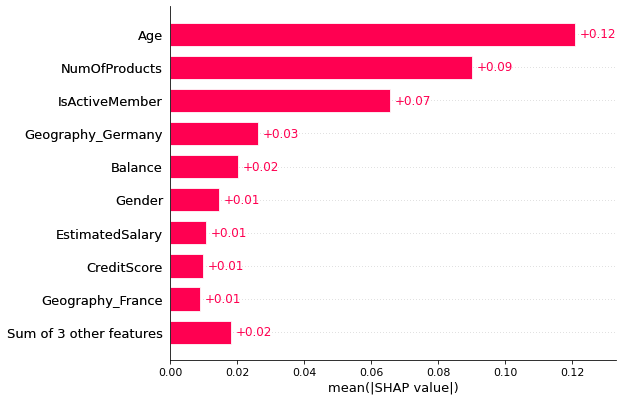

In [41]:
shap.plots.bar(shap_values)

**Customer's age, number of products, and their activeness** have more influence on the final prediction outcome.

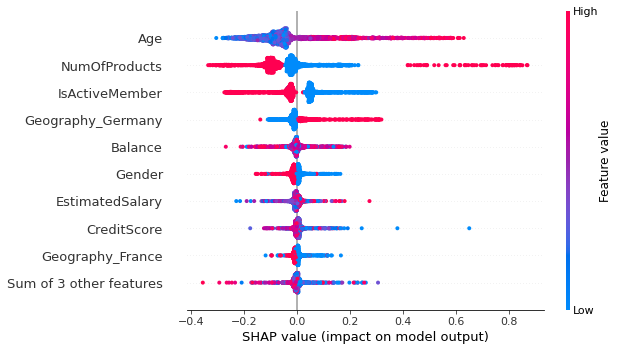

In [42]:
shap.plots.beeswarm(shap_values)

It is clear from the above beeswarm plot that in the random forest model, **customers of higher age and customers from Germany** tend to increase the likelyhood of being classified as churn, while **active customers** are less likely to be identified as churn.

However, it is unclear whether **the number of products** the customers subscribe to has any direct relationship with the rate of churn. But for customers who subscribe to more products, this feature tend to have more impact on the model decision, as indicated by the high absolute value of their SHAP values.